In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from SRP import Vector_file
import pandas as pd
import moods
import topics
import seaborn as sns
import numpy as np
from scipy.stats import entropy
pd.set_option("display.max_colwidth", 100)

In [31]:
dictionary = Dictionary.load('data/bills_prune.dict')
lda_40 = LdaModel.load('data/lda_40.gensim')
lda_40._dictionary = dictionary
annotations = pd.read_csv('data/lda_40.annotations.gz')
annotations.query('useful == "Yes"').sample(2)

,Unnamed: 0,category,useful,words
30,30,Water,Yes,flood lake status louisiana map promotion hurricane islands internal pennsylvania commonwealth p...
8,8,Health Planning,Yes,family effective life violation enterprise significant role lakes incorporate phase contractual ...


In [4]:
meta = pd.read_csv('bill-meta.csv', index_col='id')
meta[['title']].head(3)

,title
id,
115 H.R. 3823,Disaster Tax Relief and Airport and Airway Extension Act of 2017
115 H.R. 88,Shiloh National Military Park Boundary Adjustment and Parker's Crossroads Battlefield Designatio...
115 H.R. 1,An Act to provide for reconciliation pursuant to titles II and V of the concurrent resolution on...


## Topic auto-ETA

These are the words with the highest prior - that is, the words most likely to occur in any given bill, lacking any other information.

In [32]:
tr = topics.TopicReport(lda_40)
tr.general_words()

enter make senate october congress amend h.r. new relate note write end chapter september consider sec house development definition place community facility subparagraph performance record finding fiscal year december table legislative environmental . project effective resource value act improvement america


## RQ1: What are the most novel bills?

In [20]:
all_words = []
for name, txt in moods.cleaned_txts_iter('data/cleaned_by_sponsor.gz'):
    all_words += txt
bow = dictionary.doc2bow(all_words)
allvec = np.array([prob for topicno, prob in lda_40.get_document_topics(bow, minimum_probability=-1)])
del all_words
allvec

array([7.0284209e-03, 3.5624795e-03, 5.6893476e-03, 1.0661915e-03,
       5.4757907e-03, 2.1333992e-02, 2.3288333e-03, 2.2730443e-01,
       5.3960783e-03, 4.3022786e-03, 6.1276876e-03, 3.0445510e-03,
       4.6281272e-01, 1.2674802e-03, 7.3134713e-03, 1.7407869e-03,
       4.0666992e-03, 2.9230239e-03, 5.2871313e-03, 2.4004695e-03,
       3.7473866e-03, 4.9186386e-03, 9.7012427e-03, 7.6181698e-03,
       9.2182271e-02, 1.4538744e-03, 4.7167088e-03, 2.2774749e-03,
       4.5069377e-03, 8.8211047e-03, 4.3533784e-03, 9.7071212e-03,
       2.7001556e-03, 4.2484622e-04, 5.5842223e-03, 1.7950295e-02,
       4.9907230e-03, 2.5918001e-02, 1.7593451e-03, 6.1962646e-03],
      dtype=float32)

In [41]:
entropy_data = []
with Vector_file('data/topic-dists-title.bin', mode='r') as vecf:
    for name, vec in vecf:
        d = entropy(allvec, vec)
        h = entropy(vec)
        jsdist = moods.JSD(allvec, vec)
        bill = name[6:].replace('-', '.').replace('_', ' ')
        entropy_data.append((bill, d, h, jsdist))
highest_h = pd.DataFrame(entropy_data, columns=['bill', 'kl', 'entropy', 'jsd']).set_index('bill')
meta[['kl', 'entropy', 'jsd']] = highest_h.loc[meta.index]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  # Remove the CWD from sys.path while we load stuff.


In [44]:
meta[['Title', 'entropy']].sort_values('entropy', ascending=True)

,Title,entropy
id,,
110 H.R. 3043,"Departments of Labor, Health and Human Services, and Education, and Related Agencies Appropriati...",2.124835
109 S. 895,Rural Water Supply Act of 2006,2.126475
112 H.R. 2112,"Consolidated and Further Continuing Appropriations Act, 2012",2.127796
102 S. 1306,ADAMHA Reorganization Act,2.128572
109 H.R. 3010,"Departments of Labor, Health and Human Services, and Education, and Related Agencies Appropriati...",2.128946
102 H.R. 5677,"Departments of Labor, Health and Human Services, and Education, and Related Agencies Appropriati...",2.129704
103 H.R. 4606,"Departments of Labor, Health and Human Services, and Education, and Related Agencies Appropriati...",2.130036
106 H.R. 1141,1999 Emergency Supplemental Appropriations Act,2.131169
113 S. 994,DATA Act,2.131903


In [46]:
# Only look at longer bills
subset = num_sections[num_sections > 100].index

NameError: name 'num_sections' is not defined

In [632]:
meta.loc[subset].sort_values('entropy', ascending=False)[['Title', 'entropy']].head()

,Title,entropy
bill,,
110 H.R. 6849,"To amend the commodity provisions of the Food, Conservation, and Energy Act of 2008 to permit pr...",2.417300
110 S. 1193,Albuquerque Indian School Act,2.410526
101 H.R. 4328,"Textile, Apparel, and Footwear Trade Act of 1990",2.372031
102 H.R. 3435,"Resolution Trust Corporation, Refinancing, Restructuring, and Improvement Act of 1991",2.304364
101 H.R. 2710,Fair Labor Standards Amendments of 1989,2.302957


In [634]:
a = meta.loc[subset].sort_values('kl', ascending=False)[['title', 'kl', 'subject']]
a.head(10)

,Title,kl,Subject
bill,,,
103 H.R. 1632,"To amend title 11, District of Columbia Code, to remove gender-specific references.",1.233989,Government Operations and Politics
112 H.R. 4281,Surface Transportation Extension Act of 2012,0.882612,Transportation and Public Works
108 H.R. 4219,"Surface Transportation Extension Act of 2004, Part II",0.859846,Transportation and Public Works
109 H.R. 2566,Surface Transportation Extension Act of 2005,0.818777,Transportation and Public Works
108 H.R. 3850,Surface Transportation Extension Act of 2004,0.765662,Transportation and Public Works
108 H.R. 4635,"Surface Transportation Extension Act of 2004, Part III",0.715118,Transportation and Public Works
114 H.R. 3996,"Surface Transportation Extension Act of 2015, Part II",0.706956,Transportation and Public Works
112 H.R. 6064,Temporary Surface Transportation Extension Act of 2012,0.681934,Transportation and Public Works
109 H.R. 3104,"Surface Transportation Extension Act of 2005, Part II",0.681309,Transportation and Public Works


A lot of amendments and extensions, because the language jumps in and out.

In [636]:
a[~a.Title.str.contains('amend|exten|adjust', case=False)].head(10)

,Title,kl,Subject
bill,,,
111 H.R. 4380,United States Manufacturing Enhancement Act of 2010,0.575838,Foreign Trade and International Finance
114 H.R. 2353,Highway and Transportation Funding Act of 2015,0.563399,Transportation and Public Works
115 S. 3170,CyberTipline Modernization Act of 2018,0.487744,Crime and Law Enforcement
111 H.R. 6198,Bankruptcy Technical Corrections Act of 2010,0.477878,Finance and Financial Sector
104 H.R. 2739,House of Representatives Administrative Reform Technical Corrections Act,0.398602,Congress
104 H.R. 3864,General Accounting Office Act of 1996,0.392224,Congress
109 H.R. 5585,Financial Netting Improvements Act of 2006,0.382211,Finance and Financial Sector
110 H.R. 1195,SAFETEA-LU Technical Corrections Act of 2008,0.374953,Transportation and Public Works
115 S. 3479,Department of Veterans Affairs Expiring Authorities Act of 2018,0.362526,Armed Forces and National Security


In [642]:
a = meta.loc[subset].sort_values('entropy', ascending=False)[['Title', 'entropy', 'Subject']]
a[::50]

,Title,entropy,Subject
bill,,,
110 H.R. 6849,"To amend the commodity provisions of the Food, Conservation, and Energy Act of 2008 to permit pr...",2.417300,Agriculture and Food
104 H.R. 956,Product Liability Fairness Act of 1995,2.166923,Commerce
109 H.R. 6111,Tax Relief and Health Care Act of 2006,2.109303,Taxation
109 S. 161,Northern Arizona Land Exchange and Verde River Basin Partnership Act of 2005,2.075383,Public Lands and Natural Resources
105 H.R. 872,Biomaterials Access Assurance Act of 1998,2.053792,Commerce
101 H.R. 1594,Customs and Trade Act of 1990,2.029456,Foreign Trade and International Finance
103 S. 349,Lobbying Disclosure Act of 1994,2.013316,Government Operations and Politics
110 H.R. 1585,National Defense Authorization Act for Fiscal Year 2008,1.995636,Armed Forces and National Security
105 H.R. 3055,Miccosukee Reserved Area Act,1.975697,Native Americans


# Topic Entropy

In [551]:
with Vector_file('data/topic-dists-sponsor.bin') as vfile:
    data = vfile.to_matrix()

In [552]:
# Senate difference from House
diff = data['matrix'][1] - data['matrix'][0]
diff_ind = pd.Series(diff).sort_values().index

In [624]:
annotations[annotations.useful == 'Yes'][['category', 'words']]

,category,words
0,Appropriations,appropriations conservation participate goal portion monitoring transmit adoption assess annuall...
1,Family,foundation contribution parent guarantee expenses kind have beneficial jointly partner identity ...
5,Land Use,land interior foot manner performance engineers october site commercial railroad list specific f...
8,Health Planning,family effective life violation enterprise significant role lakes incorporate phase contractual ...
9,History/Memorial,recommendation history human approved legislative h.r. fail barrier adequate fully memorial lose...
10,Corporations,corporation cultural enhance involve current mission ability expand money mitigate historical ai...
11,Forests,reclamation conform exchange forest disabilities execute manage refuge exception suitable overal...
14,Transactions,redesignate deposit direct sale provider liability charge transaction disclosure impose aggregat...
16,Banking Regulation,board modify preservation bank judge ongoing rent fifth avoid expedite circuit merit reorganizat...
17,Employment,employment market industry particularly reflect cash collaboration difference unemployment draft...


In [554]:
print('Top Senate Markers')
annotations.loc[diff_ind].query('useful == "Yes"')[:10]

Top Senate Markers


,category,useful,words
23,Bio/Chem,Yes,remain obligation loss eligibility device responsible physical examination expert chemical waive...
0,Appropriations,Yes,appropriations conservation participate goal portion monitoring transmit adoption assess annuall...
1,Family,Yes,foundation contribution parent guarantee expenses kind have beneficial jointly partner identity ...
17,Employment,Yes,employment market industry particularly reflect cash collaboration difference unemployment draft...
10,Corporations,Yes,corporation cultural enhance involve current mission ability expand money mitigate historical ai...
25,Retirement,Yes,respectively retirement accounting advancement records employees inspector administration soon c...
19,Compensation,Yes,compensation behalf factor valley worker inform waste intent cross occupational potentially incu...
28,Leave and Relief,Yes,percent medical file employ run town leave verify hour regularly duly 12-month lane furnished em...
14,Transactions,Yes,redesignate deposit direct sale provider liability charge transaction disclosure impose aggregat...
33,Judiciary,Yes,amend n following islamist 1950 prophylaxis killer emergence terrorists caveat goldwater overcro...


In [241]:
print('Top House Markers')
annotations.loc[diff_ind].query('useful == "Yes"')[:-10:-1]

Top House Markers


,category,useful,words
18,Disability,Yes,disability find second city assemble finding w...
10,Corporations,Yes,corporation cultural enhance involve current m...
33,Judiciary,Yes,amend n following islamist 1950 prophylaxis ki...
19,Compensation,Yes,compensation behalf factor valley worker infor...
36,Property and Compensation,Yes,enter definition lieu home owner association u...
26,Ports and Place,Yes,appear place coast port applicant border repre...
16,Banking Regulation,Yes,board modify preservation bank judge ongoing r...
25,Retirement,Yes,respectively retirement accounting advancement...
17,Employment,Yes,employment market industry particularly reflec...


In [569]:
with Vector_file('data/topic-dists-congress.bin') as vfile:
    data = vfile.to_matrix()

In [570]:
all_diffs = data['matrix'][1:] - data['matrix'][:-1]
all_diffs.shape

(15, 40)

In [575]:
meta.Congress.sort_values().unique()

array(['100th Congress (1987-1988)', '101st Congress (1989-1990)',
       '102nd Congress (1991-1992)', '103rd Congress (1993-1994)',
       '104th Congress (1995-1996)', '105th Congress (1997-1998)',
       '106th Congress (1999-2000)', '107th Congress (2001-2002)',
       '108th Congress (2003-2004)', '109th Congress (2005-2006)',
       '110th Congress (2007-2008)', '111th Congress (2009-2010)',
       '112th Congress (2011-2012)', '113th Congress (2013-2014)',
       '114th Congress (2015-2016)', '115th Congress (2017-2018)',
       '116th Congress (2019-2020)', '93rd Congress (1973-1974)',
       '94th Congress (1975-1976)', '95th Congress (1977-1978)',
       '96th Congress (1979-1980)', '97th Congress (1981-1982)',
       '98th Congress (1983-1984)', '99th Congress (1985-1986)'],
      dtype=object)

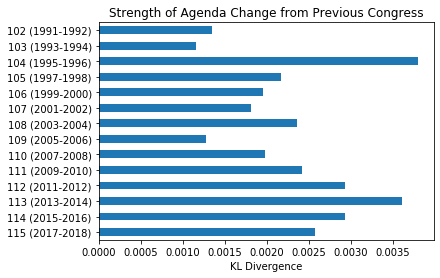

In [650]:
labels = ["%d (%d-%d)" % (100+i, 1987+i*2, 1988+i*2) for i in range(1, 17)]
ax = pd.Series(change_in_kl, index=labels[1:])[:-1][::-1].plot(kind='barh', title="Strength of Agenda Change from Previous Congress")
ax.set_xlabel("KL Divergence")
ax

In [623]:
change_in_kl = []
for i in range(len(data['names'])-1):
    print("Main differences from congress %s to %s" % (data['names'][i][-3:], data['names'][i+1][-3:]))
    diff = all_diffs[i]
    diff_ind = pd.Series(diff).sort_values().index
    sorted_cats = annotations.loc[diff_ind].query('useful == "Yes"')['category'].tolist()
    D = entropy(data['matrix'][i], data['matrix'][i+1])
    change_in_kl.append(D)
    #print("\tentropy scaled:", int(D*10**5))
    print("\tFalling priorities:", ", ".join(sorted_cats[:5]))
    print("\tGrowing priorities:", ", ".join(sorted_cats[:-5:-1]))

Main differences from congress 101 to 102
	Falling priorities: Land, Transactions, Banking Regulation, Judiciary, Forests
	Growing priorities: Leave and Relief, Corporations, Employment, Disability
Main differences from congress 102 to 103
	Falling priorities: Property and Compensation, Employment, Family, Leave and Relief, Disability
	Growing priorities: Aerospace and Defense, Land Use, Ports and Place, Transactions
Main differences from congress 103 to 104
	Falling priorities: Disability, Land Use, Ports and Place, Aerospace and Defense, Appropriations
	Growing priorities: Transactions, Property and Compensation, Banking Regulation, Land
Main differences from congress 104 to 105
	Falling priorities: Banking Regulation, Property and Compensation, Transactions, Health Planning, Land
	Growing priorities: Disability, Bio/Chem, Land Use, Appropriations
Main differences from congress 105 to 106
	Falling priorities: Bio/Chem, Property and Compensation, Aerospace and Defense, Disability, Ret

Text(0.5, 0, 'Proportion of text on topic')

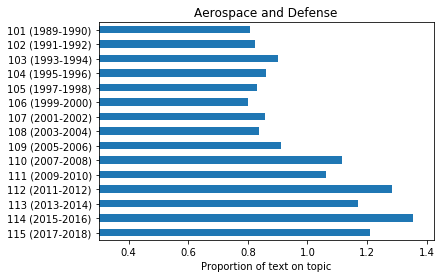

In [749]:
i += 1
ax = pd.Series(data['matrix'][:-1, i] * 100, index=labels[:-1])[::-1].plot(kind='barh', xlim=(0.3), title=annotations.iloc[i]['category'])
ax.set_xlabel("Proportion of text on topic")

category                                                                                               Land Use
useful                                                                                                      Yes
words       land interior foot manner performance engineers october site commercial railroad list specific f...
Name: 5, dtype: object
category                                                                                        Health Planning
useful                                                                                                      Yes
words       family effective life violation enterprise significant role lakes incorporate phase contractual ...
Name: 8, dtype: object


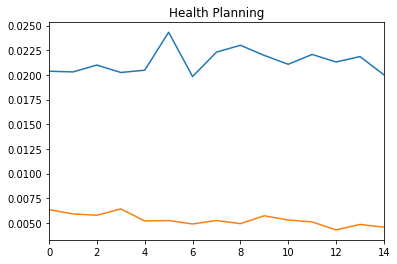

In [735]:
%matplotlib inline

for i, row in annotations.query('useful == "Yes"').iloc[2:4].iterrows():
    # Ignore current congress because data is small
    pd.Series(data['matrix'][:-1, i]).plot(title=row['category'])
    print(row)

In [333]:
# Create Reference for how many sections there are in each bill
allnames = []
with Vector_file('data/topic-dists-para.bin', mode='r') as vecf:
    for name, vec in vecf:
        parts = name.split('_')
        bill = "_".join(parts[1:-1])
        section = parts[-1]
        allnames.append((bill.replace('-', '.').replace('_', ' '), int(section)))
num_sections = pd.DataFrame(allnames, columns=['bill', 'seq']).groupby('bill')['seq'].max().sort_values(ascending=False)

In [822]:
# Most Sections
meta.loc[num_sections[:200].index, 'Title'].sample(10)

bill
105 H.R. 4194    Departments of Veterans Affairs and Housing and Urban Development, and Independent Agencies Appr...
114 H.R. 2029                                                                  Consolidated Appropriations Act, 2016
105 H.R. 2015                                                                            Balanced Budget Act of 1997
104 H.R. 1561                                        Foreign Relations Authorization Act, Fiscal Years 1996 and 1997
114 S. 2943                                                  National Defense Authorization Act for Fiscal Year 2017
108 H.R. 3550                           Safe, Accountable, Flexible, and Efficient Transportation Equity Act of 2004
103 S. 2182                                                  National Defense Authorization Act for Fiscal Year 1995
110 H.R. 1495                                                                Water Resources Development Act of 2007
106 H.R. 2488                                              

In [825]:
billname = "108 H.R. 3550" #'105 H.R. 4194'
cleanbillname = billname.replace('.', '-').replace(' ', '_')
n = num_sections.loc[billname]
secnames = ["para_%s_%d" % (cleanbillname,i) for i in range(n)]
secnames[:10]
with Vector_file('data/topic-dists-para.bin', mode='r') as vecf:
    paravecs = vecf[secnames]
with Vector_file('data/topic-dists-title.bin', mode='r') as vecf:
    billvec = vecf['title_' + cleanbillname]

b = moods.Bill('/data/bills/txt/%s.txt' % cleanbillname)

In [828]:
all_h = []
for i, line in enumerate(b.lines()):
    h = int(100*entropy(billvec, paravecs[i]))
    all_h.append(h)
    if len(line.split()) > 20: 
        if h >27:
            print(i, "\tKL:", h)
            print(line[:1000], "\n")
    else:
        pass
        # print(i, "Too short to measure")

989 	KL: 29
``Sec. 174. National historic covered bridge preservation ``(a) Definition of Historic Covered Bridge. In this section, the term `historic covered bridge' means a covered bridge that is listed or eligible for listing on the National Register of Historic Places. ``(b) Historic Covered Bridge Preservation. Subject to the availability of appropriations, the Secretary shall  ``(1) collect and disseminate information on historic covered bridges; ``(2) conduct educational programs relating to the history and construction techniques of historic covered bridges; ``(3) conduct research on the history of historic covered bridges; and ``(4) conduct research on, and study techniques for, protecting historic covered bridges from rot, fire, natural disasters, or weight-related damage. ``(c) Grants.  ``(1) In general. Subject to the availability of appropriations, the Secretary shall make a grant to a State that submits an application to the Secretary that demonstrates a need for assistan

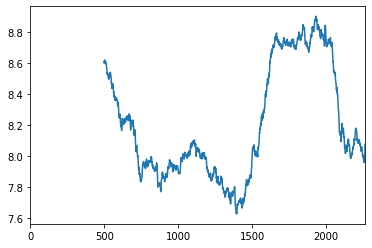

In [777]:
pd.Series(all_h).rolling(window=500).mean().plot()

In [359]:
for i in range(paravecs.shape[0]):
    print(i, int(100*entropy(paravecs[i], billvec)))

0 10
1 8
2 8
3 12
4 9
5 12
6 14
7 3
8 9
9 10
10 10
11 19
12 10
13 8
14 7
15 10
16 9
17 10
18 14
19 10
20 6
21 6
22 10
23 10
24 10
25 7
26 11
27 8
28 10
29 7
30 20
31 5
32 7
33 7
34 8
35 11
36 8
37 10
38 12
39 20
40 9
41 17
42 8
43 11
44 7
45 17
46 14
47 15
48 9
49 11
50 18
51 9
52 10
53 9
54 9
55 11
56 9
57 12
58 11
59 11
60 14
61 19
62 11
63 12
64 14
65 7
66 13
67 30
68 9
69 12
70 7
71 6
72 10
73 11
74 13
75 14
76 18
77 12
78 18
79 18
80 15
81 13
82 8
83 13
84 21
85 8
86 29
87 13
88 15
89 15
90 17
91 10
92 19
93 26
94 13
95 22
96 16
97 15
98 9
99 7
100 24
101 10
102 22
103 12
104 20
105 9
106 25
107 13
108 10
109 14
110 33
111 13
112 18
113 8
114 18
115 31
116 10
117 18
118 10
119 12
120 8
121 18
122 8
123 7
124 16
125 9
126 19
127 8
128 10
129 7
130 11
131 8
132 8
133 8
134 8
135 28
136 11
137 11
138 16
139 10
140 13
141 21
142 11
143 18
144 10
145 9
146 14
147 15
148 14
149 12
150 9
151 7
152 8
153 24
154 11
155 9
156 20
157 10
158 10
159 8
160 17
161 18
162 10
163 15
164 16
165 16


## Differences between bills

# Unexpected Passages